<div class="alert alert-block alert-success" style="margin-top: 20px">  
    
<a id='ThirdSection'> <H1> Third Assignment - Explore and cluster the Toronto Neighborhood</H1></a>  

 3.1. <a href='#31'>Following the Previous Lab Methodology</a>  <br>
 
 3.2. <a href='#32'>Subsetting to East, Central, Downtown, and West Toronto</a>   <br>
 
 3.3. <a href='#33'>Decoupling Neighborhood</a>    <br>
 
 3.4. <a href='#34'>Map of East, Central, Downtown, and West Toronto Neighborhood</a>    <br>
 
 3.5. <a href='#35'>FourSquare API</a>  <br>
 
 3.6. <a href='#36'>Preprocessing Neighborhood</a>   <br>
 
 3.7. <a href='#37'>K-Means Clustering</a>   <br>
 
 3.8. <a href='#38'>Cluster Map</a>   <br>
 
 3.9. <a href='#39'>Examine Cluster</a>   
     
</div>

Import a couple dependancies before we start:

In [77]:
# Segmenting and Clustering Neighborhoods in Toronto
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Let's load the csv files from the first two assignments on Week3-Toronto.ipynb:

In [2]:
cleaned_df2 = pd.read_csv('toronto_lat_long.csv')
cleaned_df2.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"West Hill, Morningside, Guildwood",43.763573,-79.188711
3,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
4,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577


<a id='31'>Following the Previous Lab Methodology</a>  
Just checking on the number of boroughs and neighborhoods from cleaned_df2 and df dataframe:

In [3]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(cleaned_df2['Borough'].unique()),
        len(cleaned_df2['Neighborhood'].unique())
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>toronto_explorer</em>, as shown below.

In [4]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [5]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(cleaned_df2['Latitude'], cleaned_df2['Longitude'], cleaned_df2['Borough'], cleaned_df2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Notice that there are multiple neighborhood per marker. It will be decoupled in the next couple of lines.

Let's explore the Boroughs in the dataframe:

In [6]:
cleaned_df2['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'West Toronto', 'York',
       'Etobicoke', "Queen's Park", 'Mississauga'], dtype=object)

<a id='32'>Subsetting to East, Central, Downtown, and West Toronto</a>  
[Back to the top](#ThirdSection)    
We are going to subset the data and only specify the 'East Toronto', 'Central Toronto', 'Downtown Toronto' , and 'West Toronto' Borough using ```str.contains```:

In [7]:
toronto_data = cleaned_df2[cleaned_df2['Borough'].str.contains('Toronto')]
# reset the index:
toronto_data = toronto_data.reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
1,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
2,M4T,Central Toronto,"Summerhill East, Moore Park",43.689574,-79.383160
3,M4V,Central Toronto,"Rathnelly, Deer Park, South Hill, Summerhill W...",43.686412,-79.400049
4,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675


In [8]:
# shape of the data:
toronto_data.shape

(38, 5)

<a id='33'>Decoupling Neighborhood</a>  
[Back to the top](#ThirdSection)    
There are multiple neighborhood for each postal code, so I will decouple them and get the latitude and longitude using the Nominatim (geocode) function.

First let's check which rows have one neighborhood and which rows have multiple neighborhood:

In [9]:
# for test:
len(toronto_data['Neighborhood'][0].split(','))

2

In [10]:
# to get the row:
toronto_data.shape[0]

38

In [11]:
one_neigh= []
mult_neigh = []
for i in range(toronto_data.shape[0]):
    countN = len(toronto_data['Neighborhood'][i].split(','))
    if countN > 1:
        mult_neigh.append(i)
    elif countN == 1:
        one_neigh.append(i)

In [12]:
toronto_data_mult = toronto_data.loc[mult_neigh]
toronto_data_mult.shape

(23, 5)

In [13]:
toronto_data_one = toronto_data.loc[one_neigh]
toronto_data_one.shape

(15, 5)

In [14]:
toronto_data_one

,PostalCode,Borough,Neighborhood,Latitude,Longitude
23,M4E,East Toronto,The Beaches,43.676357,-79.293031
24,M4M,East Toronto,Studio District,43.659526,-79.340923
25,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
26,M4P,Central Toronto,Davisville North,43.712751,-79.390197
27,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
28,M4S,Central Toronto,Davisville,43.704324,-79.388790
29,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
30,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
31,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
32,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


We will keep the ```toronto_data_one``` DataFrame and decouple the ```toronto_data_mult``` DataFrame:

In [15]:
neighbor_list = []
for neigh in toronto_data_mult['Neighborhood']:
    neighbor_list.append(neigh)
neighbor_list[:5]

['The Danforth West, Riverdale',
 'India Bazaar, The Beaches West',
 'Summerhill East, Moore Park',
 'Rathnelly, Deer Park, South Hill, Summerhill West, Forest Hill SE',
 'Cabbagetown, St. James Town']

In [16]:
# decoupling the neighbor_list:
new = [i.split(', ') for i in neighbor_list]
# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
neighbor_list = [item for sublist in new for item in sublist]
neighbor_list[:10]

['The Danforth West',
 'Riverdale',
 'India Bazaar',
 'The Beaches West',
 'Summerhill East',
 'Moore Park',
 'Rathnelly',
 'Deer Park',
 'South Hill',
 'Summerhill West']

Let's use the `geopy` package using Nominatim geolocation service:

In [17]:
lat_to = []
long_to = []
for neigh in neighbor_list:
    address = "{}, Toronto, ON".format(neigh)
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    if location is not None:
        lat_to.append(location.latitude)
        long_to.append(location.longitude)
    else:
        lat_to.append(np.nan)
        long_to.append(np.nan)

Create a new dataframe entitled `neighborhoods`:

In [18]:
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [19]:
# filling the neighborhoods dataframe with what we got earlier:
neighborhoods['Neighborhood'] = neighbor_list
neighborhoods['Latitude']= lat_to
neighborhoods['Longitude']= long_to

In [20]:
neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,The Danforth West,43.686360,-79.300316
1,Riverdale,43.665470,-79.352594
2,India Bazaar,43.672223,-79.323503
3,The Beaches West,43.671024,-79.296712
4,Summerhill East,43.681678,-79.390504


In [21]:
# let's see the null values:
neighborhoods[neighborhoods['Latitude'].isnull()]

,Neighborhood,Latitude,Longitude
42,Railway Lands,NaN,NaN


Cross-checking the `Railway Lands` neighborhoods with the toronto_data dataframe to see their values:m

In [22]:
toronto_data.loc[toronto_data['Neighborhood'].str.contains('Railway Lands')]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
15,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.39442


The *Railway Lands* are amongst other downtown Toronto neighborhood Postal Code. I am comfortable with deleting this one.

In [23]:
neighborhoods = neighborhoods.drop(neighborhoods[neighborhoods['Neighborhood'] == 'Railway Lands'].index)

In [24]:
# let's see the null values:
neighborhoods[neighborhoods['Latitude'].isnull()]

,Neighborhood,Latitude,Longitude


**We remove all the ```null``` values**

Next, let's re-add the Borough column by taking the `toronto_data_mult` DataFrame and creating a list comprehension:

In [25]:
borough_list = [list(toronto_data_mult.loc[toronto_data_mult['Neighborhood'].str.contains(neigh)]['Borough']) 
 for neigh in neighborhoods['Neighborhood']]

In [26]:
borough_list[:15]

[['East Toronto'],
 ['East Toronto'],
 ['East Toronto'],
 ['East Toronto'],
 ['Central Toronto'],
 ['Central Toronto'],
 ['Central Toronto'],
 ['Central Toronto'],
 ['Central Toronto'],
 ['Central Toronto'],
 ['Central Toronto'],
 ['Downtown Toronto'],
 ['Downtown Toronto'],
 ['Downtown Toronto', 'Downtown Toronto', 'Downtown Toronto'],
 ['Downtown Toronto']]

There are rows that have multiple values, so I will only take the first one using another list comprehension:

In [27]:
borough_list = [borough_list[i][0] for i in range(len(borough_list))]
# check the length of the borough list
len(borough_list)

58

In [28]:
# checking the final product:
borough_list[:15]

['East Toronto',
 'East Toronto',
 'East Toronto',
 'East Toronto',
 'Central Toronto',
 'Central Toronto',
 'Central Toronto',
 'Central Toronto',
 'Central Toronto',
 'Central Toronto',
 'Central Toronto',
 'Downtown Toronto',
 'Downtown Toronto',
 'Downtown Toronto',
 'Downtown Toronto']

In [29]:
# make sure that the dataframe has the same length
neighborhoods.shape

(58, 3)

In [30]:
# let's insert the borough value into neighborhoods dataframe
neighborhoods.insert(0,'Borough',borough_list)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,East Toronto,The Danforth West,43.686360,-79.300316
1,East Toronto,Riverdale,43.665470,-79.352594
2,East Toronto,India Bazaar,43.672223,-79.323503
3,East Toronto,The Beaches West,43.671024,-79.296712
4,Central Toronto,Summerhill East,43.681678,-79.390504


Now let's re-add the `toronto_data_one` DataFrame into the `neighborhoods` DataFrame. In order to do so, I will drop the Postal Code column to match the columns with one another: 

In [31]:
toronto_data_one = toronto_data_one.drop('PostalCode',axis=1)

Now let's rejoin the toronto_data_one and the neighborhoods:

In [32]:
neighborhoods = pd.concat([neighborhoods,toronto_data_one])
neighborhoods.sort_values(by='Borough')
neighborhoods = neighborhoods.reset_index(drop=True)

In [33]:
neighborhoods.head(15)

,Borough,Neighborhood,Latitude,Longitude
0,East Toronto,The Danforth West,43.686360,-79.300316
1,East Toronto,Riverdale,43.665470,-79.352594
2,East Toronto,India Bazaar,43.672223,-79.323503
3,East Toronto,The Beaches West,43.671024,-79.296712
4,Central Toronto,Summerhill East,43.681678,-79.390504
5,Central Toronto,Moore Park,43.690388,-79.383297
6,Central Toronto,Rathnelly,43.677472,-79.400460
7,Central Toronto,Deer Park,43.688090,-79.394093
8,Central Toronto,South Hill,43.677926,-79.405767
9,Central Toronto,Summerhill West,43.681678,-79.390504


As we did with all of Toronto, let's visualize the smaller subset and the neighborhoods in it:

In [34]:
# create map of Toronto using latitude and longitude values
map_subset = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'],neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_subset)  
    
map_subset

We see that there are two anomalies:
1. Underground city
2. Richmond

They are both from downtown Toronto Borough, but located outside the city. So, I will need to fix this right now:

In [35]:
# Underground City taken from toronto_data:
toronto_data.loc[toronto_data['Neighborhood'].str.contains('Underground city')]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
16,M5X,Downtown Toronto,"Underground city, First Canadian Place",43.648429,-79.38228


In [36]:
# from the neighborhoods data frame:
neighborhoods.loc[neighborhoods['Neighborhood'].str.contains('Underground city')]

,Borough,Neighborhood,Latitude,Longitude
43,Downtown Toronto,Underground city,43.770145,-79.374863


Looking at the geocoder function and see where the error lies:

In [37]:
address = 'Underground city, Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude
#print('The geograpical coordinate are {}, {}.'.format(latitude, longitude))
print(location)

The Underground, 794a, Sheppard Avenue East, Bayview Village, Don Valley North, North York, Toronto, Ontario, M2K 1C3, Canada


The query pointed towards North York Borough, instead of downtown Toronto. So, using google, I found the coordinate to be: 43.6516645, -79.3816759. 

In [38]:
underground_loc = neighborhoods.loc[neighborhoods['Neighborhood'].str.contains('Underground city')].index

In [39]:
# let's replace them with the value that I obtained from google maps:
neighborhoods.loc[underground_loc,'Latitude'] = 43.6516645
neighborhoods.loc[underground_loc,'Longitude'] = -79.3816759

In [40]:
neighborhoods.loc[underground_loc]

,Borough,Neighborhood,Latitude,Longitude
43,Downtown Toronto,Underground city,43.651665,-79.381676


Moving our attention to Richmond:

In [41]:
# Richmond taken from toronto_data:
toronto_data.loc[toronto_data['Neighborhood'].str.contains('Richmond')]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
7,M5H,Downtown Toronto,"King, Adelaide, Richmond",43.650571,-79.384568


In [42]:
# from the neighborhoods data frame:
neighborhoods.loc[neighborhoods['Neighborhood'].str.contains('Richmond')]

,Borough,Neighborhood,Latitude,Longitude
19,Downtown Toronto,Richmond,43.812589,-79.26337


Looking at the original query and seeing where the error lies:

In [43]:
address = 'Richmond, Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
print(location)

Richmond Park, Agincourt North, Scarborough North, Scarborough, Toronto, Golden Horseshoe, Ontario, Canada


It points toward Richmond Park in the borough of Scarborough, instead of the Richmond Street in downtown Toronto. So, let's modify the query into *'Richmond Street'*:

In [44]:
address = 'Richmond St, Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(location)
print('The geograpical coordinate are {}, {}.'.format(latitude, longitude))

Richmond Street, PATH, Downtown Yonge, Toronto Centre, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5H 3W4, Canada
The geograpical coordinate are 43.6517899, -79.3790908.


In [45]:
richmond_loc = neighborhoods.loc[neighborhoods['Neighborhood'].str.contains('Richmond')].index
#richmond_loc

In [46]:
neighborhoods.loc[richmond_loc,'Latitude'] = latitude
neighborhoods.loc[richmond_loc,'Longitude'] = longitude

In [47]:
# for sanity check:
neighborhoods.loc[richmond_loc]

,Borough,Neighborhood,Latitude,Longitude
19,Downtown Toronto,Richmond,43.65179,-79.379091


In [48]:
# let's save it to a csv so that I can use it later:
neighborhoods.to_csv('toronto_subset.csv',index=False)

<a id='34'>Map of East, Central, Downtown, and West Toronto Neighborhood</a>  
[Back to the top](#ThirdSection)    
Let's recreate the map with the correct Latitude and Longitude:

In [49]:
# create map of Toronto using latitude and longitude values
map_subset = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'],neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_subset)  
    
map_subset

<a id='35'>FourSquare API</a>  
[Back to the top](#ThirdSection)    
Now, let's use the foursquare API to explore the neighborhoods and segment them. I am hiding the code since I do not want to show my client ID and client secret to the world.

In [50]:
CLIENT_ID = pd.read_csv('FSclientID.txt',header=None)[0][0] # your Foursquare ID
CLIENT_SECRET = pd.read_csv('FSclientSecret.txt',header=None)[0][0] # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Let's explore the first neighborhood in our dataframe.

The name of the neighborhood is:

In [51]:
neighborhoods.loc[0, 'Neighborhood']

'The Danforth West'

Let's get the longitude and latitude of the neighborhood:

In [52]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

#### Now, let's get the top 100 venues that are in 'The Danforth West' within a radius of 500 meters.

In [53]:
# define radius
radius = 500
# limit of number of venues returned by Foursquare API
LIMIT = 100
search_query = 'venues'
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    VERSION, 
    radius, 
    LIMIT)
results = requests.get(url).json()
#results

Let's borrow the **get_category_type** function from the Foursquare lab:

In [54]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's clean the json and structure it into a *pandas* dataframe.

In [55]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Ted Reeve Arena,Skating Rink,43.684527,-79.299426
1,Beach Hill Smokehouse,BBQ Joint,43.684105,-79.300410
2,Duckworth's Fish and Chips,Fish & Chips Shop,43.688629,-79.299952
3,Cool Runnings,Caribbean Restaurant,43.683497,-79.300017
4,Sultan Shawarma & Falafel,Middle Eastern Restaurant,43.688223,-79.301709


How many venues returned by FourSquare?

In [56]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

26 venues were returned by Foursquare.


## Explore the neighborhoods methodically:  
#### Let's borrow the 'getNearbyVenue' function from the lab: 

In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [58]:
# let's put them into one place:
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

In [59]:
# let's save the DataFrame so that I do not need to call it every single time I rerun the Jupyter notebook:
toronto_venues.to_csv('toronto_venues.csv',index=False)

In [60]:
# once we have done the above two lines, we can just easily get the DataFrame using:
toronto_venues = pd.read_csv('toronto_venues.csv')

In [61]:
# let's explore the DataFrame:
print(toronto_venues.shape)
toronto_venues.head()

(3780, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Danforth West,43.68636,-79.300316,Ted Reeve Arena,43.684527,-79.299426,Skating Rink
1,The Danforth West,43.68636,-79.300316,Beach Hill Smokehouse,43.684105,-79.300410,BBQ Joint
2,The Danforth West,43.68636,-79.300316,Duckworth's Fish and Chips,43.688629,-79.299952,Fish & Chips Shop
3,The Danforth West,43.68636,-79.300316,Cool Runnings,43.683497,-79.300017,Caribbean Restaurant
4,The Danforth West,43.68636,-79.300316,Sultan Shawarma & Falafel,43.688223,-79.301709,Middle Eastern Restaurant


#### Let's find out how many unique categories can be curated from all the returned venues

In [62]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 292 uniques categories.


<a id='36'>Preprocessing venues</a>  
[Back to the top](#ThirdSection)    
## Analyze Each Neighborhood

In [63]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

In [64]:
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
toronto_onehot.head()

,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# where does "Neighborhood" located in toronto_onehot dataframe?
toronto_onehot.columns.get_loc('Neighborhood')

188

In [66]:
# saving it to a variable, since we are going to use it multiple times:
num_neigh_to_one= toronto_onehot.columns.get_loc('Neighborhood')

In [67]:
# just for sanity check:
toronto_onehot.columns[num_neigh_to_one]

'Neighborhood'

In [68]:
fixed_columns = [toronto_onehot.columns[num_neigh_to_one]]+list(toronto_onehot.columns[:num_neigh_to_one])+list(toronto_onehot.columns[num_neigh_to_one+1:])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,The Danforth West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Danforth West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Danforth West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Danforth West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Danforth West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Checking the `toronto_onehot` DataFrame size:

In [69]:
toronto_onehot.shape

(3780, 292)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [70]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.010000,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.0,0.0
1,Bathurst Quay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0
2,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.017544,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0
3,Brockton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.105263,0.0,0.00,0.0,0.0,0.0,0.0
4,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0


Checking the `toronto_grouped` DataFrame size:

In [71]:
toronto_grouped.shape

(72, 292)

In [72]:
# if we want to print the top 5 venues
#  num_top_venues = 5

#for hood in toronto_grouped['Neighborhood']:
#    print("----"+hood+"----")
#    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
#    temp.columns = ['venue','freq']
#    temp = temp.iloc[1:]
#    temp['freq'] = temp['freq'].astype(float)
#    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')

#### Let's put that into a *pandas* dataframe  
Borrowing from the lab: 

In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [74]:
num_top_venues = 10
# for: 1st, 2nd, and 3rd
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        # for first, second, third, use this one:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        # others use nth for the column name:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Hotel,Gastropub,Restaurant,Café,Italian Restaurant,Breakfast Spot,Seafood Restaurant,Cosmetics Shop,Japanese Restaurant
1,Bathurst Quay,Coffee Shop,Café,Park,Pub,Grocery Store,Garden,Bank,Sculpture Garden,Diner,Recreation Center
2,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Café,Cheese Shop,Bakery,Beer Bar,Steakhouse,Farmers Market,Fountain
3,Brockton,Bar,Vietnamese Restaurant,Park,Dive Bar,Grocery Store,Middle Eastern Restaurant,French Restaurant,Bakery,Gastropub,Korean Restaurant
4,Business Reply Mail Processing Centre 969 Eastern,Spa,Smoke Shop,Auto Workshop,Fast Food Restaurant,Garden,Light Rail Station,Burrito Place,Restaurant,Skate Park,Park


<a id='37'>K-Means Clustering</a>  
[Back to the top](#ThirdSection)    
## Cluster Neighborhoods

First let's run multiple K values to find the optimal number of clusters for this particular dataset:

In [75]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 22)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_) #km.inertia_: Sum of squared distances of samples to their closest cluster center.

Plot the K:

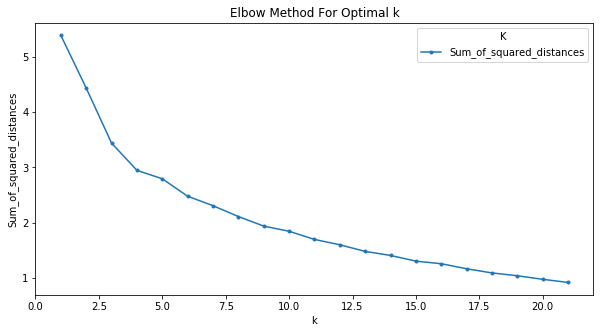

In [87]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
optimal_k.plot(kind = 'line', figsize = (10, 5), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The best K value seems to be 5 for our datasets.

Run *k*-means to cluster the neighborhood into 5 clusters.

In [79]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [80]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,The Danforth West,43.686360,-79.300316,0,Coffee Shop,Bus Line,BBQ Joint,Sushi Restaurant,Fast Food Restaurant,Caribbean Restaurant,Bakery,Sandwich Place,Baseball Field,Café
1,East Toronto,Riverdale,43.665470,-79.352594,0,Vietnamese Restaurant,Chinese Restaurant,Bakery,Bar,Breakfast Spot,Dim Sum Restaurant,Cheese Shop,Fish Market,Asian Restaurant,Baseball Field
2,East Toronto,India Bazaar,43.672223,-79.323503,0,Indian Restaurant,Café,Halal Restaurant,Grocery Store,Pet Store,Asian Restaurant,Diner,Bar,Egyptian Restaurant,Sandwich Place
3,East Toronto,The Beaches West,43.671024,-79.296712,0,Beach,Bakery,Park,Bar,Tea Room,Thai Restaurant,Breakfast Spot,Japanese Restaurant,Coffee Shop,Pizza Place
4,Central Toronto,Summerhill East,43.681678,-79.390504,0,Italian Restaurant,French Restaurant,Coffee Shop,Café,Sushi Restaurant,Pizza Place,Spa,Pub,Bakery,Bank


<a id='38'>Cluster Map</a>  
[Back to the top](#ThirdSection)    
Finally, let's visualize the resulting clusters

In [81]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='39'>Examine Cluster</a>  
[Back to the top](#ThirdSection)    

Now, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

#### Cluster 1

In [82]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0,1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,The Danforth West,Coffee Shop,Bus Line,BBQ Joint,Sushi Restaurant,Fast Food Restaurant,Caribbean Restaurant,Bakery,Sandwich Place,Baseball Field,Café
1,East Toronto,Riverdale,Vietnamese Restaurant,Chinese Restaurant,Bakery,Bar,Breakfast Spot,Dim Sum Restaurant,Cheese Shop,Fish Market,Asian Restaurant,Baseball Field
2,East Toronto,India Bazaar,Indian Restaurant,Café,Halal Restaurant,Grocery Store,Pet Store,Asian Restaurant,Diner,Bar,Egyptian Restaurant,Sandwich Place
3,East Toronto,The Beaches West,Beach,Bakery,Park,Bar,Tea Room,Thai Restaurant,Breakfast Spot,Japanese Restaurant,Coffee Shop,Pizza Place
4,Central Toronto,Summerhill East,Italian Restaurant,French Restaurant,Coffee Shop,Café,Sushi Restaurant,Pizza Place,Spa,Pub,Bakery,Bank
6,Central Toronto,Rathnelly,French Restaurant,Park,Italian Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Electronics Store,American Restaurant,Shoe Repair,Liquor Store
7,Central Toronto,Deer Park,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Sushi Restaurant,Thai Restaurant,Pub,Pizza Place,Restaurant,Bagel Shop
8,Central Toronto,South Hill,Coffee Shop,Sandwich Place,History Museum,Café,Pizza Place,Mexican Restaurant,Indian Restaurant,Liquor Store,Steakhouse,Jewish Restaurant
9,Central Toronto,Summerhill West,Italian Restaurant,French Restaurant,Coffee Shop,Café,Sushi Restaurant,Pizza Place,Spa,Pub,Bakery,Bank
11,Downtown Toronto,Cabbagetown,Restaurant,Coffee Shop,Café,Italian Restaurant,Japanese Restaurant,Gastropub,Indian Restaurant,Bakery,Diner,Pub


`Cluster 1` has either Coffee Shop/Cafe or Restaurant as the first two most common venue. It can be categorized as the **hangout** cluster

#### Cluster 2

In [83]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0,1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,West Toronto,Swansea,Park,Skating Rink,Dance Studio,Zoo,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
60,Central Toronto,Lawrence Park,Park,Bus Line,Swim School,Zoo,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
64,Downtown Toronto,Rosedale,Park,Building,Playground,Trail,Zoo,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store


`Cluster 2` has Park as the first most common venue. They all have Ethiopian Restaurant, Dumpling Restaurant, Eastern European Restaurant, Egyptian Restaurant, Zoo, Donut Shop, and Electronic Store as well. This can be designated as the **family oriented** cluster

#### Cluster 3

In [84]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0,1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,Central Toronto,Roselawn,Garden,Zoo,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant


`Cluster 3` is located in the Central Toronto Borough and is in the Roselawn neighborhood. 

#### Cluster 4

In [85]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0,1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Central Toronto,Forest Hill SE,Playground,Park,Mediterranean Restaurant,Bank,Zoo,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
27,Central Toronto,Forest Hill West,Playground,Park,Mediterranean Restaurant,Bank,Zoo,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
28,Central Toronto,Forest Hill North,Playground,Park,Mediterranean Restaurant,Bank,Zoo,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store


`Cluster 4` is located in the Central Toronto Borough and in the Forest Hill neighborhood.

#### Cluster 5

In [86]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0,1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Central Toronto,Moore Park,Convenience Store,Gym,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space


`Cluster 5` is located in the Central Toronto Borough in the Moore Park neighborhood. 